![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Optimization problem over nonnegative trigonometric polynomials. #

We consider the trigonometric polynomial
 
$$H(\omega) = x_0 + 2 \sum_{k=1}^n [ \Re(x_k) \cos(\omega k) + \Im(x_k) \sin(\omega k) ],$$

where $H(\omega)$ is a real valued function paramtrized by the complex vector $x\in {\bf C}^{n+1}$, and where $\Im(x_0)=0$.

The example shows how to construct a *non-negative* polynomial $H(\omega)\geq 0, \: \forall \omega$ that satisfies,
  
$$1 - \delta \leq  H(\omega) \leq 1 + \delta, \quad  \forall \omega \in [0, \omega_p]$$

while minimizing $\sup_{\omega\in [\omega_s,\pi]} H(\omega)$ over the variables $x$.

In the signal processing literature such a trigonometric polynomial is known as (the squared amplitude response of) a Chebyshev lowpass filter. 

A squared amplitude response $H(\omega)$ is always symmetric around $0$, so $\Im(x_k)=0$, and we consider only

$$H(\omega) = x_0 + 2 \sum_{k=1}^n x_k \cos(\omega k) $$

over the real vector $x\in {\bf R}^{n+1}$. However, the concepts in the example are readily applied to the case with $x\in {\bf C}^{n+1}$.

References:
  1. "Squared Functional Systems and Optimization Problems",  Y. Nesterov, 2004.
  
  2. "Convex Optimization of Non-negative Polynomials: Structured Algorithms and Applications", Ph.D thesis, Y. Hachez, 2003.


In [1]:
import mosek
from   mosek.fusion import *
from   math import cos, pi
import numpy as np
import sys

### Nonnegativity everywhere ###

Nesterov proved in [1] that $H(\omega) \geq 0, \: \forall \omega$ if and only if 
$$x_i = \langle T_i^{n+1}, X \rangle, \quad X \in {\mathcal H}^{n+1}_+,$$
where ${\mathcal H}_+$ is the cone of Hermitian semidefinite matrices and $T_i$ is a Toeplitz matrix
$$[T_i]_{kl} = \left \{ \begin{array}{ll}1, & k-l=i\\0 & \text{otherwise}.\end{array} \right .$$
For example, for $n=2$ we have
$$
   T_0 = \left[\begin{array}{ccc}
   1 & 0 & 0\\0 & 1 & 0\\0 & 0 & 1
   \end{array}
   \right], \quad
   T_1 = \left[\begin{array}{ccc}
   0 & 0 & 0\\1 & 0 & 0\\0 & 1 & 0
   \end{array}
   \right],
   \quad
   T_2 = \left[\begin{array}{ccc}
   0 & 0 & 0\\0 & 0 & 0\\1 & 0 & 0
   \end{array}
   \right].
$$
In our case we have $\Im(x_i)=0$, i.e., $X\in {\mathcal S}^{n+1}_+$ is a real symmetric semidefinite matrix.

We define the *cone on nonnegative trigonometric polynomials* as
$$
   K^n_{0,\pi} = \{ x\in \mathbf{R} \times \mathbf{C}^n \mid x_i = \langle X, T_i\rangle, \: i=0,\dots,n, \: X\in\mathcal{H}_+^{n+1} \}.
$$

In [2]:
def T_dot_X(n, i, X, a=1.0):
    if i>=n or i<=-n: return Expr.constTerm(0.0)
    else: return Expr.dot(Matrix.diag(n, a, -i), X)

In [3]:
def trigpoly_0_pi(M, x):
    '''x[i] == <T(n+1,i),X>'''
    n = int(x.getSize()-1)
    X = M.variable("X", Domain.inPSDCone(n+1))
    
    for i in range(n+1):
        M.constraint(Expr.sub(T_dot_X(n+1,i,X), x.index(i)), Domain.equalsTo(0.0))

Note that we have dropped the imaginary part of $X$.

### Nonnegativity on $[0,a]$ ###

Similarly, $H(\omega)$ is nonnegative on $[0,a]$ if and only if

$$x_i =
\langle X_1, T_i^{n+1} \rangle + 
\langle X_2, T_{i+1}^n \rangle +
\langle X_2, T_{i-1}^n \rangle -
2 \cos(a)\langle X_2, T_{i}^n \rangle, \quad 
X_1 \in {\mathcal H}^{n+1}_+, \:
X_2 \in {\mathcal H}^n_+,
$$
or equivalently
$$
  K^n_{0,a} = \{ x\in \mathbf{R}\times \mathbf{C}^n \mid
   x_i = \langle X_1, T_i^{n+1} \rangle +
   \langle X_2 , T_{i+1}^n \rangle +
   \langle X_2 , T_{i-1}^n \rangle -
   2\cos(a)\langle X_2 , T_i^n\rangle, \: X_1\in \mathcal{H}_+^{n+1}, X_2\in\mathcal{H}_+^n \}.
$$

In [4]:
def trigpoly_0_a(M, x, a):
    '''x[i] == <T(n+1,i),X1> + <T(n,i+1),X2> + <T(n,i-1),X2> - 2*cos(a)*<T(n,i),X2>'''
    n = int(x.getSize()-1)
    X1 = M.variable(Domain.inPSDCone(n+1))
    X2 = M.variable(Domain.inPSDCone(n))

    for i in range(n+1):
        M.constraint(Expr.sub(Expr.add([ T_dot_X(n+1,i,X1), 
                                         T_dot_X(n,i+1,X2), 
                                         T_dot_X(n,i-1,X2), 
                                         T_dot_X(n,i,X2,-2*cos(a))]),
                              x.index(i)), Domain.equalsTo(0.0))

Note that we have dropped the imaginary part of $X_1$ and $X_2$.

### Nonnegativity on $[a,\pi]$ ###

Finally, $H(\omega)$ is nonnegative on $[a,\pi]$ if and only if

$$x_i = 
\langle X_1, T_i^{n+1} \rangle -
\langle X_2, T_{i+1}^n \rangle -
\langle X_2, T_{i-1}^n \rangle +
2 \cos(a)\langle X_2, T_{i}^n \rangle, \quad 
X_1 \in {\mathcal S}^{n+1}_+, \:
X_2 \in {\mathcal S}^n_+,
$$
or equivalently
$$
  K^n_{a,\pi} = \{ x\in \mathbf{R}\times \mathbf{C}^n \mid
   x_i = \langle X_1, T_i^{n+1} \rangle -
   \langle X_2 , T_{i+1}^n \rangle -
   \langle X_2 , T_{i-1}^n \rangle +
   2\cos(a)\langle X_2 , T_i^n\rangle, \: X_1\in \mathcal{H}_+^{n+1}, X_2\in\mathcal{H}_+^n \}.
$$

In [5]:
def trigpoly_a_pi(M, x, a):
    '''x[i] == <T(n+1,i),X1> - <T(n,i+1),X2> - <T(n,i-1),X2> + 2*cos(a)*<T(n,i),X2>'''
    n = int(x.getSize()-1)
    X1 = M.variable(Domain.inPSDCone(n+1))
    X2 = M.variable(Domain.inPSDCone(n))

    for i in range(n+1):
        M.constraint(Expr.add([ T_dot_X(n+1,i,X1), 
                                T_dot_X(n,i+1,X2,-1.0), 
                                T_dot_X(n,i-1,X2,-1.0), 
                                T_dot_X(n,i,X2,2*cos(a)),
                                Expr.neg(x.index(i))    ]),
                     Domain.equalsTo(0.0))

Note that we have dropped the imaginary part of $X_1$ and $X_2$.

## An epigraph formulation ##
The *epigraph* $H(\omega) \leq t$ can now be characterized simply as 
$-u \in K^n_{[a,b]}, \: u=(x_0-t, \, x_{1:n}).$

In [6]:
def epigraph(M, x, t, a, b):
    '''Models 0 <= H(w) <= t, for all w in [a, b], where
         H(w) = x0 + 2*x1*cos(w) + 2*x2*cos(2*w) + ... + 2*xn*cos(n*w)'''
    n  = int(x.getSize()-1)    
    u = M.variable(n+1, Domain.unbounded())
    M.constraint(Expr.sub(t,Expr.add(x.index(0), u.index(0))), Domain.equalsTo(0.0)) 
    M.constraint(Expr.add(x.slice(1,n+1), u.slice(1,n+1)), Domain.equalsTo(0.0))
    
    if a==0.0 and b==pi:
        trigpoly_0_pi(M, u)
    elif a==0.0 and b<pi:
        trigpoly_0_a(M, u, b)
    elif a<pi and b==pi:
        trigpoly_a_pi(M, u, a)
    else:
        raise ValueError("invalid interval.")

## A hypograph formulation ##
Similarly, the *hypograph* $H(\omega) \geq t$ can be characterized as 
$u \in K^n_{[a,b]}, \: u=(x_0-t, \, x_{1:n}).$

In [7]:
def hypograph(M, x, t, a, b):
    '''Models 0 <= t <= H(w), for all w in [a, b], where
         H(w) = x0 + 2*x1*cos(w) + 2*x2*cos(2*w) + ... + 2*xn*cos(n*w)'''

    n  = int(x.getSize()-1)    
    u0 = M.variable(1, Domain.unbounded())    
    M.constraint(Expr.sub(t,Expr.sub(x.index(0), u0)), Domain.equalsTo(0.0))
    u = Var.vstack( u0, x.slice(1, n+1) )

    if a==0.0 and b==pi:
        trigpoly_0_pi(M, u)
    elif a==0.0 and b<pi:
        trigpoly_0_a(M, u,  b)
    elif a<pi and b==pi:
        trigpoly_a_pi(M, u, a)
    else:
        raise ValueError("invalid interval.")

## Putting it together ##

In [8]:
n = 10
M = Model("trigpoly")
x = M.variable("x", n+1, Domain.unbounded())

### Global nonnegativity ###

In [9]:
# H(w) >= 0
trigpoly_0_pi(M, x)

### Passband specifications ###

In [10]:
wp = pi/4
delta = 0.05

# H(w) <= (1+delta), w in [0, wp]    
epigraph(M, x, 1.0+delta, 0.0, wp)

# (1-delta) <= H(w), w in [0, wp]
hypograph(M, x, 1.0-delta, 0.0, wp)

### Stopband specifications ###

In [11]:
ws = wp + pi/8

# H(w) < t, w in [ws, pi]
t = M.variable("t", 1, Domain.greaterThan(0.0))
epigraph(M, x, t, ws, pi)

### Setting the objective ###

In [12]:
M.objective(ObjectiveSense.Minimize, t)

In [13]:
M.setLogHandler(sys.stdout)

In [14]:
M.solve()

Problem
  Name                   : trigpoly        
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 67              
  Cones                  : 0               
  Scalar variables       : 35              
  Matrix variables       : 7               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 23
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   : trigpoly        
  Objective s

In [15]:
x.level()

array([ 0.33580937,  0.25254317,  0.1388759 ,  0.02044169, -0.04797007,
       -0.05156956, -0.01627207,  0.01837092,  0.02948826,  0.02271378,
       -0.00952669])

In [16]:
t.level()

array([0.0727316])

### Plotting the amplitude response ###

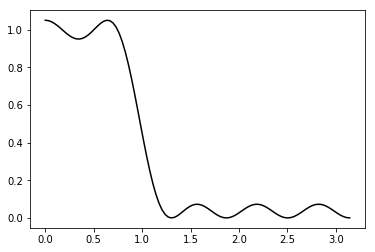

In [17]:
xx = x.level()
def H(w): return xx[0] + 2*sum([xx[i]*cos(i*w) for i in range(1,len(xx))])
w  = np.linspace(0, pi, 100)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(w, [H(wi) for wi in w], 'k')
plt.show()


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 

